In [3]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_PATH = "world_pop_mig_186_countries.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df_raw = pd.read_csv(DATA_PATH)
df_raw.shape

(11904, 5)

In [4]:
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

country_col = next((c for c in df.columns if "country" in c), None)
year_col = "year" if "year" in df.columns else next((c for c in df.columns if "year" in c), None)

assert country_col is not None, "Set country_col manually."
assert year_col is not None, "Set year_col manually."

df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
df = df.dropna(subset=[year_col])
df[year_col] = df[year_col].astype(int)

df = df.sort_values([country_col, year_col]).reset_index(drop=True)
(df.head(), df[[country_col, year_col]].duplicated().sum(), (df[year_col].min(), df[year_col].max()), df[country_col].nunique())

(       country  year  population  netmigration  population_in_millions
 0  Afghanistan  1960   8622466.0        2606.0                       8
 1  Afghanistan  1961   8790140.0        6109.0                       8
 2  Afghanistan  1962   8969047.0        7016.0                       8
 3  Afghanistan  1963   9157465.0        6681.0                       9
 4  Afghanistan  1964   9355514.0        7079.0                       9,
 np.int64(0),
 (1960, 2023),
 186)

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
pop_candidates = [c for c in numeric_cols if ("pop" in c) or ("population" in c)]
mig_candidates = [c for c in numeric_cols if ("mig" in c) or ("migration" in c)]

(pop_candidates[:10], mig_candidates[:10], df.isna().mean().sort_values(ascending=False).head(15))

(['population', 'population_in_millions'],
 ['netmigration'],
 country                   0.0
 year                      0.0
 population                0.0
 netmigration              0.0
 population_in_millions    0.0
 dtype: float64)

In [6]:
POP_COL = pop_candidates[0] if pop_candidates else None
MIG_COL = mig_candidates[0] if mig_candidates else None

assert POP_COL is not None, "Set POP_COL manually."
assert MIG_COL is not None, "Set MIG_COL manually."

df["pop_lag1"] = df.groupby(country_col)[POP_COL].shift(1)
df["pop_growth_rate"] = (df[POP_COL] - df["pop_lag1"]) / df["pop_lag1"]
df["mig_lag1"] = df.groupby(country_col)[MIG_COL].shift(1)
df["log_pop"] = np.log(df[POP_COL].replace({0: np.nan}))

df[[country_col, year_col, POP_COL, MIG_COL, "pop_growth_rate", "mig_lag1", "log_pop"]].head(12)

,country,year,population,netmigration,pop_growth_rate,mig_lag1,log_pop
0,Afghanistan,1960,8622466.0,2606.0,NaN,NaN,15.969882
1,Afghanistan,1961,8790140.0,6109.0,0.019446,2606.0,15.989141
2,Afghanistan,1962,8969047.0,7016.0,0.020353,6109.0,16.009290
3,Afghanistan,1963,9157465.0,6681.0,0.021008,7016.0,16.030080
4,Afghanistan,1964,9355514.0,7079.0,0.021627,6681.0,16.051476
5,Afghanistan,1965,9565147.0,10695.0,0.022407,7079.0,16.073637
6,Afghanistan,1966,9783147.0,3563.0,0.022791,10695.0,16.096172
7,Afghanistan,1967,10010030.0,6824.0,0.023191,3563.0,16.119098
8,Afghanistan,1968,10247780.0,3333.0,0.023751,6824.0,16.142572
9,Afghanistan,1969,10494489.0,2029.0,0.024074,3333.0,16.166361


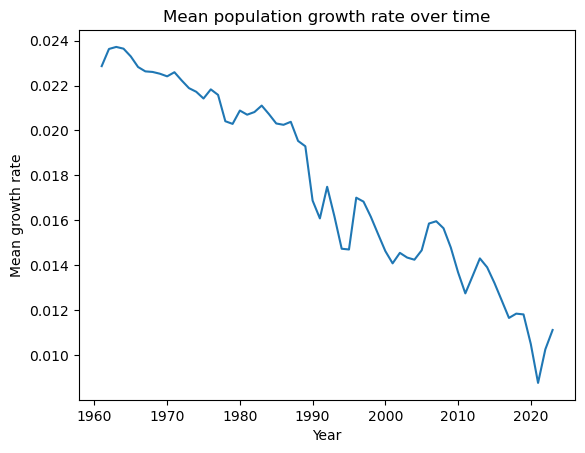

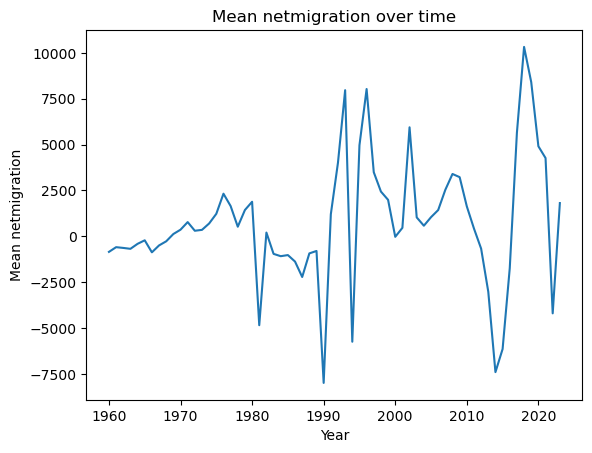

In [7]:
tmp1 = df.groupby(year_col)["pop_growth_rate"].mean().reset_index()
plt.figure()
plt.plot(tmp1[year_col], tmp1["pop_growth_rate"])
plt.title("Mean population growth rate over time")
plt.xlabel("Year")
plt.ylabel("Mean growth rate")
plt.show()

tmp2 = df.groupby(year_col)[MIG_COL].mean().reset_index()
plt.figure()
plt.plot(tmp2[year_col], tmp2[MIG_COL])
plt.title(f"Mean {MIG_COL} over time")
plt.xlabel("Year")
plt.ylabel(f"Mean {MIG_COL}")
plt.show()


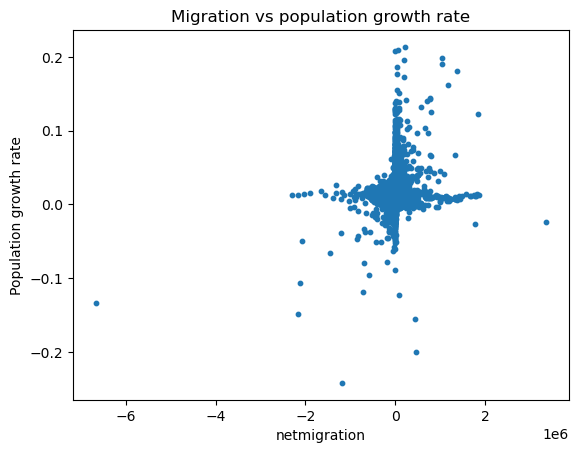

['Afghanistan', 'Norway', 'Nepal']

In [8]:
plot_df = df.dropna(subset=["pop_growth_rate", MIG_COL]).copy()
plt.figure()
plt.scatter(plot_df[MIG_COL], plot_df["pop_growth_rate"], s=10)
plt.title("Migration vs population growth rate")
plt.xlabel(MIG_COL)
plt.ylabel("Population growth rate")
plt.show()

top_countries = df[country_col].value_counts().head(3).index.tolist()
top_countries

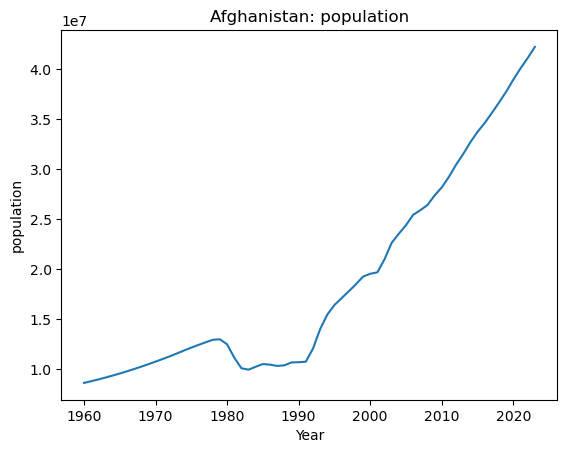

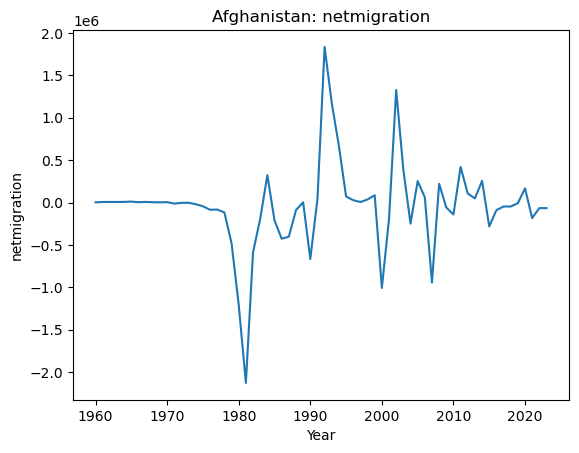

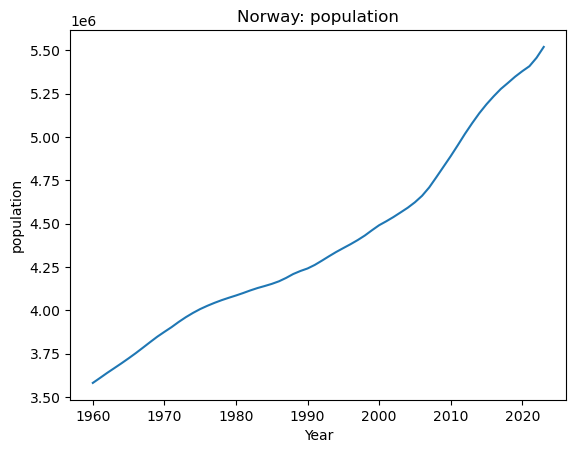

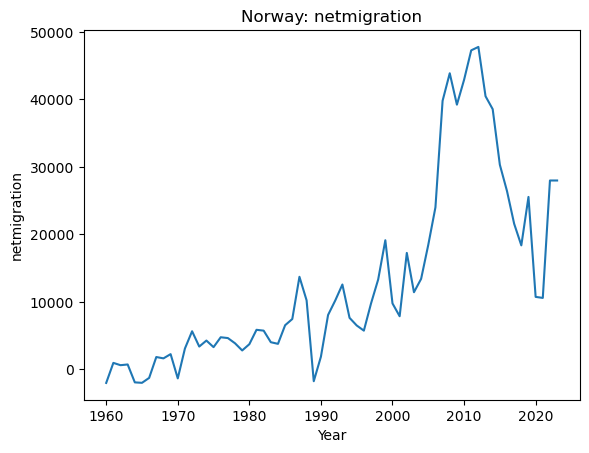

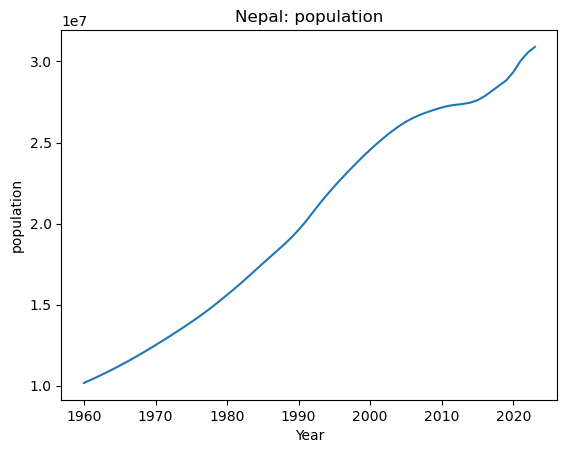

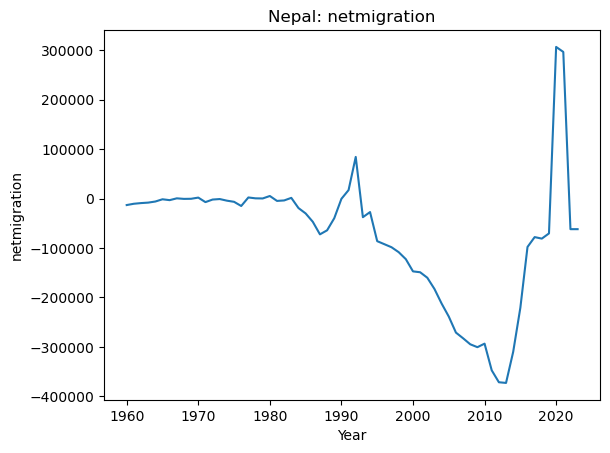

In [9]:
for c in top_countries:
    d = df[df[country_col] == c].sort_values(year_col)
    plt.figure()
    plt.plot(d[year_col], d[POP_COL])
    plt.title(f"{c}: {POP_COL}")
    plt.xlabel("Year")
    plt.ylabel(POP_COL)
    plt.show()
    
    plt.figure()
    plt.plot(d[year_col], d[MIG_COL])
    plt.title(f"{c}: {MIG_COL}")
    plt.xlabel("Year")
    plt.ylabel(MIG_COL)
    plt.show()
